In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm
plt.rcParams["figure.figsize"] = (5,4)

In [3]:
file_path = 'results/dict/'
file_name = os.listdir(file_path)

In [5]:
clip = 0.04
noise_scale = [1000.0, 100.0, 10.0, 5.0, 1.0, 0.8]
t = [norm.ppf(0.975, loc=0, scale=i*clip) for i in noise_scale]
epsilon = [0.00862, 0.0321, 0.374, 0.802, 6.85, 11.3]

In [5]:
performance_ = []
indx = []
fil = []

## Sigma 100

In [6]:
for ns in noise_scale:
    files = []
    for f in file_name:
        if 'sigma_{}'.format(ns) in f:
            files.append(f)
    best_performance_index_ns_100 = -1
    best_performance = -1
    best_file = None
    for i, file in enumerate(files):
        with open('{}{}'.format(file_path,file), 'rb') as f:
            res = pickle.load(f)
            if res['test_history_acc'][-1] > best_performance:
                best_performance = res['test_history_acc'][-1]
                best_performance_index_ns_100 = i
                best_file = file
    performance_.append(best_performance)
    indx.append(best_performance_index_ns_100)
    fil.append(best_file)

In [7]:
header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
label_dict = {
    ' <=50K': '<=50K',
    ' >50K': '>50K',
    ' <=50K.': '<=50K',
    ' >50K.': '>50K'
}
train_df = pd.read_csv('Data/Adult/adult.data', header=None)
test_df = pd.read_csv('Data/Adult/adult.test', skiprows=1, header=None)
all_data = pd.concat([train_df, test_df], axis=0)
all_data.columns = header
def hour_per_week(x):
    if x <= 19:
        return '0'
    elif (x > 19) & (x <= 29):
        return '1'
    elif (x > 29) & (x <= 39):
        return '2'
    elif x > 39:
        return '3'
def age(x):
    if x <= 24:
        return '0'
    elif (x > 24) & (x <= 34):
        return '1'
    elif (x > 34) & (x <= 44):
        return '2'
    elif (x > 44) & (x <= 54):
        return '3'
    elif (x > 54) & (x <= 64):
        return '4'
    else:
        return '5'
def country(x):
    if x == ' United-States':
        return 0
    else:
        return 1
all_data['hours-per-week'] = all_data['hours-per-week'].map(lambda x: hour_per_week(x))
all_data['age'] = all_data['age'].map(lambda x: age(x))
all_data['native-country'] = all_data['native-country'].map(lambda x: country(x))
all_data = all_data.drop(
    ['fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'capital-loss'],
    axis=1)
temp = pd.get_dummies(all_data['age'], prefix='age')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('age', axis=1)
temp = pd.get_dummies(all_data['workclass'], prefix='workclass')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('workclass', axis=1)
temp = pd.get_dummies(all_data['education'], prefix='education')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('education', axis=1)
temp = pd.get_dummies(all_data['race'], prefix='race')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('race', axis=1)
temp = pd.get_dummies(all_data['hours-per-week'], prefix='hour')
all_data = pd.concat([all_data, temp], axis=1)
all_data = all_data.drop('hours-per-week', axis=1)
all_data['income'] = all_data['income'].map(label_dict)
lb = LabelEncoder()
all_data['sex'] = lb.fit_transform(all_data['sex'].values)
lb = LabelEncoder()
all_data['income'] = lb.fit_transform(all_data['income'].values)
train_df = all_data[:train_df.shape[0]].reset_index(drop=True)
test_df = all_data[train_df.shape[0]:].reset_index(drop=True)

feature_cols = list(train_df.columns)
feature_cols.remove('income')
label = 'income'
# fold_separation(train_df, args.folds, feature_cols, label)
# male_df = train_df[train_df['sex'] == 1].copy()
# female_df = train_df[train_df['sex'] == 0].copy()

In [8]:
test_df.income.value_counts()

0    12435
1     3846
Name: income, dtype: int64

In [9]:
clipping = [0.005, 0.0001, 0.005, 0.05, 0.1, 1.0]

In [10]:
def bound(noise_scale, clip):
    return 0.001*(2*clip+8*clip*noise_scale)/2
# bound = 0.001*(2*1 + 8*1**2*1**2)/2

In [11]:
bd = []
for i, n in enumerate(noise_scale):
    bd.append(bound(n, clipping[i]))

In [12]:
max_deviation = []
for file in fil:
    with open('{}{}'.format(file_path,file), 'rb') as f:
        res = pickle.load(f)
        print(res.keys())
        max_deviation.append(max(res['male_norm'][-1], res['female_norm'][-1]))
        # if res['male'][-1] > best_performance:
        #     best_performance = res['test_history_acc'][-1]
        #     best_performance_index_ns_100 = i
        #     best_file = file

dict_keys(['train_male_history_loss', 'train_female_history_loss', 'train_male_history_acc', 'train_female_history_acc', 'val_male_history_loss', 'val_female_history_loss', 'val_male_history_acc', 'val_female_history_acc', 'test_history_loss', 'test_history_acc', 'prob_male', 'prob_female', 'demo_parity', 'male_tpr', 'female_tpr', 'equal_odd', 'male_norm', 'female_norm'])
dict_keys(['train_male_history_loss', 'train_female_history_loss', 'train_male_history_acc', 'train_female_history_acc', 'val_male_history_loss', 'val_female_history_loss', 'val_male_history_acc', 'val_female_history_acc', 'test_history_loss', 'test_history_acc', 'prob_male', 'prob_female', 'demo_parity', 'male_tpr', 'female_tpr', 'equal_odd', 'male_norm', 'female_norm'])
dict_keys(['train_male_history_loss', 'train_female_history_loss', 'train_male_history_acc', 'train_female_history_acc', 'val_male_history_loss', 'val_female_history_loss', 'val_male_history_acc', 'val_female_history_acc', 'test_history_loss', 'test_

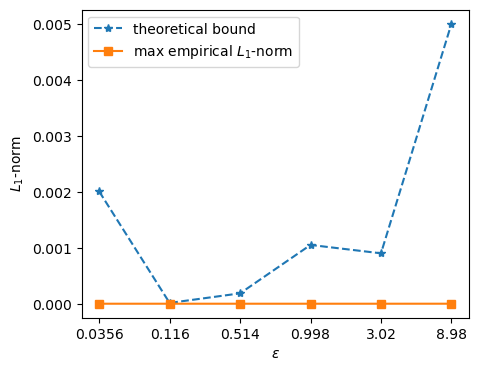

In [13]:
# eps = [0.5, 1.0, 2.0, 5.0]
plt.plot(range(len(epsilon)), bd, '--*', label='theoretical bound')
plt.plot(range(len(epsilon)), max_deviation, '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

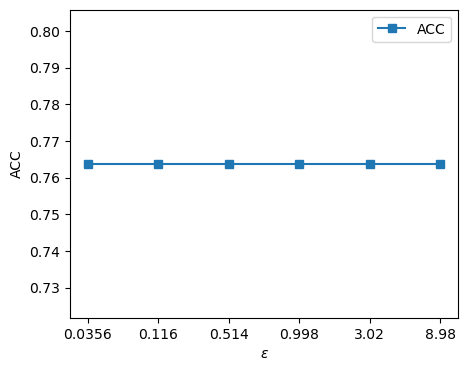

In [15]:
plt.plot(range(len(epsilon)), performance_, '-s', label=r'ACC')
plt.ylabel(r'ACC')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

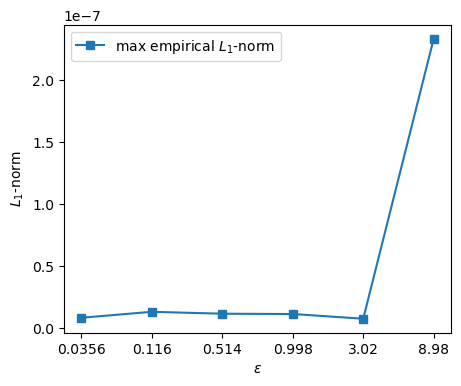

In [16]:
plt.plot(range(len(epsilon)), max_deviation, '-s', label=r'max empirical $L_1$-norm')
plt.ylabel(r'$L_1$-norm')
plt.xlabel(r'$\epsilon$')
plt.xticks(range(len(epsilon)), epsilon)
plt.legend()

In [3]:
with open('results/dict/adult_fair_fold_0_9112022_194819.pkl', 'rb') as f:
    run_fair_dict = pickle.load(f)
with open('results/dict/adult_proposed_fold_0_9112022_195457.pkl', 'rb') as f:
    run_proposed_dict = pickle.load(f)
with open('results/dict/adult_alg1_fold_0_9112022_193928.pkl', 'rb') as f:
    run_alg1_dict = pickle.load(f)

In [4]:
run_fair_dict.keys()

dict_keys(['train_global_history_loss', 'train_male_history_loss', 'train_female_history_loss', 'train_global_history_acc', 'train_male_history_acc', 'train_female_history_acc', 'val_global_history_loss', 'val_male_history_loss', 'val_female_history_loss', 'val_global_history_acc', 'val_male_history_acc', 'val_female_history_acc', 'male_norm', 'female_norm'])

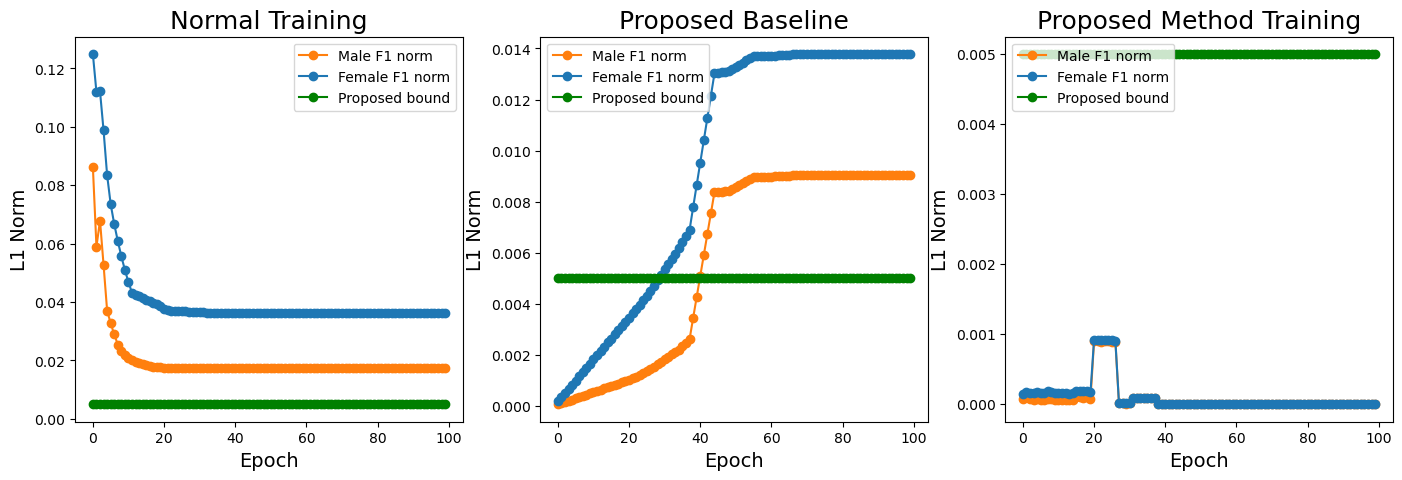

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(17,5))

axs[0].plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    np.ones(len(run_fair_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[0].set_ylabel('L1 Norm', size=14)
axs[0].set_xlabel('Epoch', size=14)
axs[0].set_title(f'Normal Training',size=18)
axs[0].legend()

axs[1].plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[1].plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    np.ones(len(run_alg1_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[1].set_ylabel('L1 Norm', size=14)
axs[1].set_xlabel('Epoch', size=14)
axs[1].set_title(f'Proposed Baseline',size=18)
axs[1].legend(loc=2)

axs[2].plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[2].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[2].set_ylabel('L1 Norm', size=14)
axs[2].set_xlabel('Epoch', size=14)
axs[2].set_title(f'Proposed Method Training',size=18)
axs[2].legend(loc=2)

Text(0, 0.5, 'L1 norm')

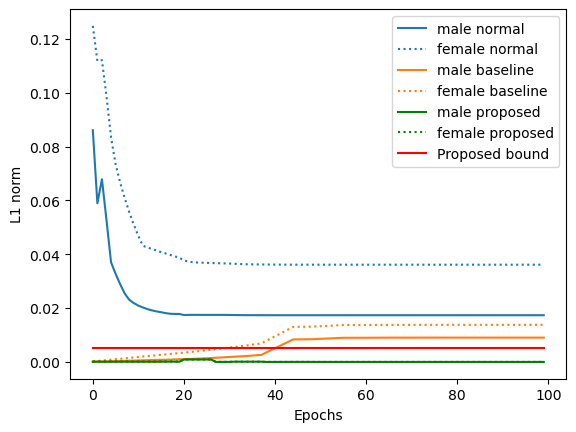

In [17]:
plt.plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-',
    label='male normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    ':',
    label='female normal',
    color='#1f77b4'
)

plt.plot(
    np.arange(len(run_alg1_dict['male_norm'])),
    run_alg1_dict['male_norm'],
    '-',
    label='male baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_alg1_dict['female_norm'])),
    run_alg1_dict['female_norm'],
    ':',
    label='female baseline',
    color='#ff7f0e'
)

plt.plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-',
    label='male proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    ':',
    label='female proposed',
    color='green'
)

plt.plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*bound,
    '-',
    label='Proposed bound',
    color='red'
)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('L1 norm')

#ff7f0e
# plt.plot(
#     np.arange(len(run_fair_dict['female_norm'])),
#     np.ones(len(run_fair_dict['female_norm']))*bound,
#     '-o',
#     label='Proposed bound',
#     color='green'

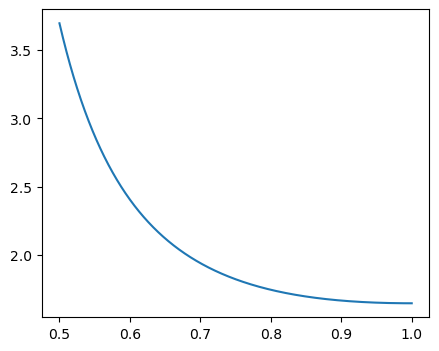

In [38]:
def f(sigma):
    return sigma*np.exp(1/(2*sigma**2))

sig = np.linspace(0.5, 1, 1000)
val = f(sig)
plt.plot(sig, val)